<a href="https://colab.research.google.com/github/33quitykubby/Rabbit_DNN_3/blob/main/Rabbit_RNN_3_simple_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

サンプルコード3_1_simple_RNN_after.ipynb  
上記同様に8bit演算の推測を行う  
LSTMのフルスクラッチ実装を断念しkerasで実装する

# 日本時間にする

In [ ]:
  !rm /etc/localtime
  !ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime
  !date

Fri May  7 07:24:21 JST 2021


# ライブラリのインポート

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
import glob

import librosa

import datetime

import gc

from sklearn.datasets import load_boston
from pandas import DataFrame

In [ ]:
#開始時刻
start_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("start_time=",start_time)

start_time= 2021-05-07 07:24:25.147545+09:00


# 乱数シードの初期化






In [ ]:
import os 
import numpy as np
from sklearn import model_selection
import tensorflow as tf
import random

COMMON_SEED = 0
STANDARD_SEED = 0
NP_SEED = 0
TF_SEED = 0 

# np.random.seed(STANDARD_SEED)
# random.seed(NP_SEED)
# tf.random.set_seed(TF_SEED)

def seed_everything():
    random.seed(STANDARD_SEED)
    os.environ['PYTHONHASHSEED'] = str(COMMON_SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    np.random.seed(NP_SEED)
    tf.random.set_seed(TF_SEED)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


In [ ]:
#乱数シード固定

seed_everything()

# デバッグプリント

In [ ]:
DEBUG = False

def debugPrint(str, debug=True):
  if debug :
    print(str)

# 共通クラス

# 共通関数

# データ準備

## 入力データ準備

8桁の2進数を生成

In [ ]:
#データ準備
#2進数の桁数
binary_dim = 8

#最大値+1
largest_number = pow(2, binary_dim)
print("largest_number=",largest_number)

#largest_numberまでの2進数を容易
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
print("binary=",binary)
print("binary.shape=",binary.shape)


largest_number= 256
binary= [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]
binary.shape= (256, 8)


In [ ]:
iters_num = 10000
# DEBUG = True

def create_datas(iters_num):
  c1 = np.empty((0,2,8),float)
  d1 = np.empty((0,8), float)

  # arr = np.append(arr, np.array([1, 2, 3]))

  for i in range(iters_num):

    a1 = np.empty((0,8), float)
    b1 = np.empty((0,8), float)

    # a + b = d
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary_encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary_encoding

    a1 = np.append(a1, [a_bin], axis=0)
    b1 = np.append(b1, [b_bin], axis=0)

    tmp = a1.copy()
    tmp = np.append(tmp, b1, axis=0)
    tmp = tmp.transpose()
    c1 = np.append(c1,tmp)
    # print(tmp)
    # print("--------------")
    # print(c1)
    # print("--------------")

    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]

    d1 = np.append(d1, [d_bin], axis=0)

    debugPrint("a:{}/{}".format(a_bin,a_int),DEBUG)
    debugPrint("b:{}/{}".format(b_bin,b_int),DEBUG)
    debugPrint("d:{}/{}".format(d_bin,d_int),DEBUG)

  c1 = np.reshape(c1, (-1, 8, 2))
  d1 = np.reshape(d1, (-1, 8, 1))

  return c1, d1

c1, d1 = create_datas(iters_num)

print(c1[1][1][1])
print(c1.shape)

print(d1[1][1])
print(d1.shape)

1.0
(10000, 8, 2)
[0.]
(10000, 8, 1)


## モデル初期値定義

In [ ]:
input_layer_size = 2
hidden_layer_size = 32
output_layer_size = 1


# LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## テストデータ作成

In [ ]:
length = c1.shape[0]
print("length=",length)

train_X = c1[:int(length*0.8),:,:]
print("trainX.shape=",train_X.shape)

val_X = c1[int(length*0.8):,:,:]
print("valX.shape=",val_X.shape)

train_Y = d1[:int(length*0.8),:,:]
print("trainY.shape=",train_Y.shape)

val_Y = d1[int(length*0.8):,:,:]
print("valY.shape=",val_Y.shape)



length= 10000
trainX.shape= (8000, 8, 2)
valX.shape= (2000, 8, 2)
trainY.shape= (8000, 8, 1)
valY.shape= (2000, 8, 1)


## モデル定義

In [ ]:
model = Sequential()

batch_input_shape_temp = (None, binary_dim, input_layer_size)

model.add(LSTM(hidden_layer_size, go_backwards=True, return_sequences=True, batch_input_shape=batch_input_shape_temp ))

model.add(Dense(output_layer_size))

model.add(Activation("sigmoid"))

optimizer = Adam(lr=0.001, decay=1e-7)

model.compile(loss="mean_squared_error", optimizer=optimizer)

early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=10)


## 学習

In [ ]:
EPOCH = 1000
batch_size = 64

history = model.fit(
                    # x=train_X, 
                    # y=train_Y, 
                    # # validation_data=(val_X, val_Y), 
                    x = c1,
                    y = d1,
                    validation_split=0.2,
                    epochs=EPOCH, 
                    callbacks=early_stopping, 
                    batch_size=64, 
                    verbose=2)



Epoch 1/1000
125/125 - 3s - loss: 0.2501 - val_loss: 0.2499
Epoch 2/1000
125/125 - 0s - loss: 0.2496 - val_loss: 0.2484
Epoch 3/1000
125/125 - 0s - loss: 0.2354 - val_loss: 0.2279
Epoch 4/1000
125/125 - 0s - loss: 0.2275 - val_loss: 0.2243
Epoch 5/1000
125/125 - 0s - loss: 0.2234 - val_loss: 0.2206
Epoch 6/1000
125/125 - 0s - loss: 0.2183 - val_loss: 0.2139
Epoch 7/1000
125/125 - 0s - loss: 0.2113 - val_loss: 0.2069
Epoch 8/1000
125/125 - 0s - loss: 0.2055 - val_loss: 0.2050
Epoch 9/1000
125/125 - 0s - loss: 0.2030 - val_loss: 0.2032
Epoch 10/1000
125/125 - 0s - loss: 0.2016 - val_loss: 0.2040
Epoch 11/1000
125/125 - 0s - loss: 0.2006 - val_loss: 0.2005
Epoch 12/1000
125/125 - 0s - loss: 0.2001 - val_loss: 0.1985
Epoch 13/1000
125/125 - 0s - loss: 0.1977 - val_loss: 0.1995
Epoch 14/1000
125/125 - 0s - loss: 0.1974 - val_loss: 0.1973
Epoch 15/1000
125/125 - 0s - loss: 0.1955 - val_loss: 0.1955
Epoch 16/1000
125/125 - 0s - loss: 0.1950 - val_loss: 0.1953
Epoch 17/1000
125/125 - 0s - loss


# `グラフ表示`

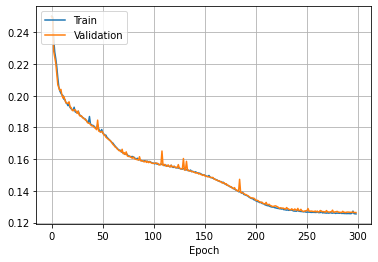

In [ ]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 推論

In [ ]:
test_X, test_Y = create_datas(100)

predict = model.predict(test_X)

In [ ]:
predict = np.reshape(predict,(100,8))
test_Y = np.reshape(test_Y,(100,8))

print("predct.shape=",predict.shape)
print("test_Y.shape=",test_Y.shape)


MAE = np.sum(np.abs(predict-test_Y))

print(MAE)

predct.shape= (100, 8)
test_Y.shape= (100, 8)
204.75937201987546


# 終わり

In [ ]:
#終了時刻
finish_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("finish_time=",finish_time)
print("total_time=",finish_time-start_time)


finish_time= 2021-05-07 07:26:47.158643+09:00
total_time= 0:02:22.011098
